In [127]:
from schema import df_sales,spark
from pyspark.sql.functions import when,col,udf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql.types import StringType,FloatType
import seaborn as sns
import numpy as np

In [128]:
def mult(quantity, price):
    return round(quantity*float(price.replace(',', '.')), 2)

multiply = udf(mult,FloatType())

def date_to_day(s):
    return datetime.strptime(s,"%d/%m/%Y").strftime('%A')

reg_sal = udf(lambda q : date_to_day(q), StringType())  

In [129]:
produit_jour_horaires = df_sales.select(["Date","Time","TicketNumber","Quantity","UnitPrice","Type"])\
                .withColumn("TimeInterval",\
                    when(df_sales.Time.rlike("07:[0-2][0-9]$"),"07:00 - 07:30")\
                    .when(df_sales.Time.rlike("07:[3-5][0-9]$"),"07:30 - 08:00")\
                    .when(df_sales.Time.rlike("08:[0-2][0-9]$"),"08:00 - 08:30")\
                    .when(df_sales.Time.rlike("08:[3-5][0-9]$"),"08:30 - 09:00")\
                    .when(df_sales.Time.rlike("09:[0-2][0-9]$"),"09:00 - 09:30")\
                    .when(df_sales.Time.rlike("09:[3-5][0-9]$"),"09:30 - 10:00")\
                    .when(df_sales.Time.rlike("10:[0-2][0-9]$"),"10:00 - 10:30")\
                    .when(df_sales.Time.rlike("10:[3-5][0-9]$"),"10:30 - 11:00")\
                    .when(df_sales.Time.rlike("11:[0-2][0-9]$"),"11:00 - 11:30")\
                    .when(df_sales.Time.rlike("11:[3-5][0-9]$"),"11:30 - 12:00")\
                    .when(df_sales.Time.rlike("12:[0-2][0-9]$"),"12:00 - 12:30")\
                    .when(df_sales.Time.rlike("12:[3-5][0-9]$"),"12:30 - 13:00")\
                    .when(df_sales.Time.rlike("13:[0-2][0-9]$"),"13:00 - 13:30")\
                    .when(df_sales.Time.rlike("13:[3-5][0-9]$"),"13:30 - 14:00")\
                    .when(df_sales.Time.rlike("14:[0-2][0-9]$"),"14:00 - 14:30")\
                    .when(df_sales.Time.rlike("14:[3-5][0-9]$"),"14:30 - 15:00")\
                    .when(df_sales.Time.rlike("15:[0-2][0-9]$"),"15:00 - 15:30")\
                    .when(df_sales.Time.rlike("15:[3-5][0-9]$"),"15:30 - 16:00")\
                    .when(df_sales.Time.rlike("16:[0-2][0-9]$"),"16:00 - 16:30")\
                    .when(df_sales.Time.rlike("16:[3-5][0-9]$"),"16:30 - 17:00")\
                    .when(df_sales.Time.rlike("17:[0-2][0-9]$"),"17:00 - 17:30")\
                    .when(df_sales.Time.rlike("17:[3-5][0-9]$"),"17:30 - 18:00")\
                    .when(df_sales.Time.rlike("18:[0-2][0-9]$"),"18:00 - 18:30")\
                    .when(df_sales.Time.rlike("18:[3-5][0-9]$"),"18:30 - 19:00")\
                    .when(df_sales.Time.rlike("19:[0-2][0-9]$"),"19:00 - 19:30")\
                    .when(df_sales.Time.rlike("19:[3-5][0-9]$"),"19:30 - 20:00")\
                    .when(df_sales.Time.rlike("20:[0-2][0-9]$"),"20:00 - 20:30"))\
                .withColumn("Day",reg_sal(col("Date")))

In [137]:
nb_jour = produit_jour_horaires.dropDuplicates(["Date"]).groupBy("Day").count().withColumnRenamed("count()","number_days")

nb_jour_pd = nb_jour.toPandas()



In [135]:
ca_produit_jour = produit_jour_horaires.withColumn("Subtotal",multiply("Quantity","UnitPrice")).groupBy("Day","Type").sum("Subtotal").withColumnRenamed("sum(Subtotal)","CA_produit")


ca_produit_jour_pd = ca_produit_jour.toPandas()


In [175]:
ca_produit_jour_horaires = produit_jour_horaires.withColumn("Subtotal",multiply("Quantity","UnitPrice")).groupBy("TimeInterval","Type").sum("Subtotal").withColumnRenamed("sum(Subtotal)","CA_produit").sort("TimeInterval")


ca_produit_semaine = produit_jour_horaires.filter(col("Day") != "Saturday").filter(col("Day") != "Sunday")\
                                    .withColumn("Subtotal",multiply("Quantity","UnitPrice")).groupBy("TimeInterval","Type").sum("Subtotal").withColumnRenamed("sum(Subtotal)","CA_produit").sort("TimeInterval")

ca_produit_weekend = produit_jour_horaires.filter(col("Day") != "Monday").filter(col("Day") != "Tuesday")\
                                            .filter(col("Day") != "Wednesday").filter(col("Day") != "Thursday")\
                                            .filter(col("Day") != "Sunday")\
                                            .withColumn("Subtotal",multiply("Quantity","UnitPrice")).groupBy("TimeInterval","Type").sum("Subtotal").withColumnRenamed("sum(Subtotal)","CA_produit").sort("TimeInterval")


ca_produit_jour_horaires_pd = ca_produit_jour_horaires.toPandas()

ca_produit_semaine_pd = ca_produit_semaine.toPandas()

ca_produit_weekend_pd = ca_produit_weekend.toPandas()


In [176]:
ca_produit_weekend.show()

+-------------+------------+------------------+
| TimeInterval|        Type|        CA_produit|
+-------------+------------+------------------+
|07:00 - 07:30|VIENNOISERIE|194.40000104904175|
|07:00 - 07:30|     BOISSON|               8.0|
|07:00 - 07:30|        SALE|               9.0|
|07:00 - 07:30|        PAIN|110.29999968409538|
|07:00 - 07:30|      GATEAU|              26.0|
|07:00 - 07:30|  CONFISERIE|               4.5|
|07:30 - 08:00|     BOISSON|              66.5|
|07:30 - 08:00|      GATEAU|350.19999945163727|
|07:30 - 08:00|        SALE|338.19999980926514|
|07:30 - 08:00|VIENNOISERIE| 2853.700007915497|
|07:30 - 08:00|  CONFISERIE|15.600000023841858|
|07:30 - 08:00|        PAIN|1914.2999980151653|
|08:00 - 08:30|        SALE| 380.6000003814697|
|08:00 - 08:30|VIENNOISERIE| 3465.400015473366|
|08:00 - 08:30|      GATEAU| 647.8000001907349|
|08:00 - 08:30|     BOISSON|             111.5|
|08:00 - 08:30|        PAIN|3562.9999980926514|
|08:00 - 08:30|  CONFISERIE|20.100000143

In [112]:
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
types = list(ca_produit_jour_pd.Type.unique())
print(types)

['SALE', 'GATEAU', 'PAIN', 'VIENNOISERIE', 'BOISSON', 'CONFISERIE']


### Graphique vente moyenne de type par jour

In [113]:
def quantity_for_day_and_type(day, type):
    try:
        nb = nb_jour_pd.loc[nb_jour_pd.Day == day].values[0][1]
        return ca_produit_jour_pd.loc[(ca_produit_jour_pd.Day==day)&(ca_produit_jour_pd.Type == type)]["CA_produit"].values[0]/nb
    except:
        return 0

In [114]:
df_plot_2 = pd.DataFrame({'type': types})
for day in DAYS:
    df_plot_2[day] = [quantity_for_day_and_type(day, type) for type in types]


In [115]:
list(df_plot_2.type)

['SALE', 'GATEAU', 'PAIN', 'VIENNOISERIE', 'BOISSON', 'CONFISERIE']

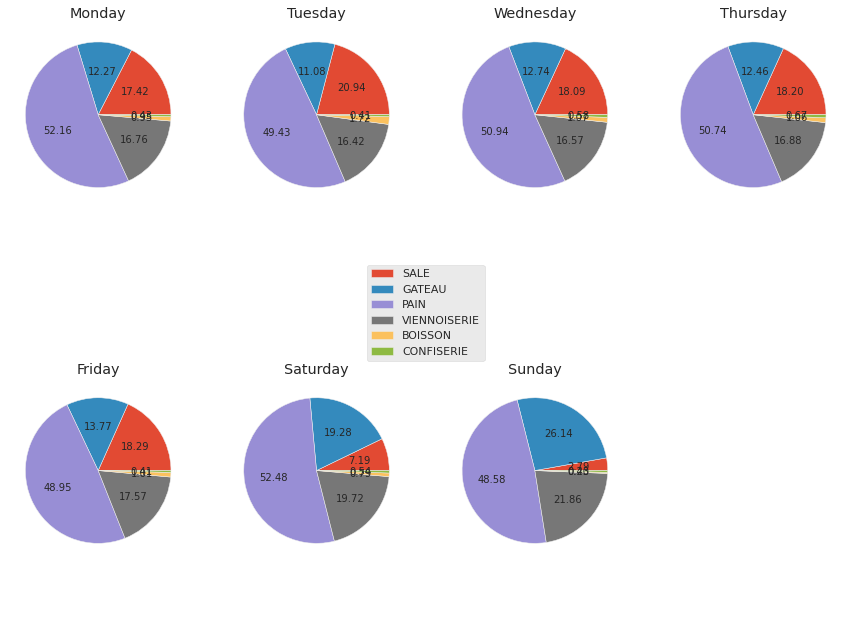

In [116]:
"""df_plot_2.filter(DAYS).plot.pie(subplots=True,figsize = (15,15))
plt.show()"""
def align_labels(labels):
    for text in labels:
        x, y = text.get_position()
        h_align = 'left' if x > 0 else 'right'
        v_align = 'bottom' if y > 0 else 'top'
        text.set(ha=h_align, va=v_align)

plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=2, ncols=4,figsize = (15,12))
for ax in axes.flat:
    ax.axis('off')
for ax, col in zip(axes.flat, df_plot_2.filter(DAYS).columns):
    artist = ax.pie(df_plot_2[col], autopct='%.2f')
    ax.set(ylabel='', title=col, aspect='equal')

    

fig.legend(artist[0],list(df_plot_2.type),loc='center')

plt.show()



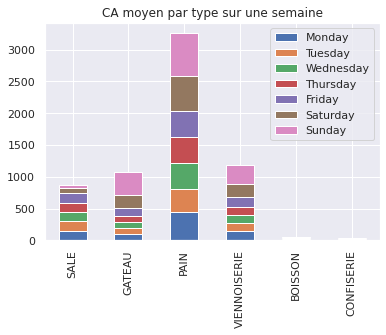

In [117]:
sns.set()
df_plot_2.plot(kind='bar', stacked=True)
plt.xticks(ticks =range(len(types)),labels = types)
plt.title("CA moyen par type sur une semaine")
plt.show()


### Graphique ventre produit par horaires

In [155]:
def ca_per_time_and_type(type,time):
    try:
        return ca_produit_jour_horaires_pd.loc[(ca_produit_jour_horaires_pd.Type==type)&(ca_produit_jour_horaires_pd.TimeInterval == time)]['CA_produit'].values[0]
    except:
        return 0


In [156]:
DAYS[5:]

['Saturday', 'Sunday']

In [157]:
def ca_per_time_and_type_sem(type,time):
    try:
        nb = 0
        for day in DAYS[:5] :
            nb += nb_jour_pd.loc[nb_jour_pd.Day == day].values[0][1]
        return ca_produit_semaine_pd.loc[(ca_produit_semaine_pd.Type==type)&(ca_produit_semaine_pd.TimeInterval == time)]['CA_produit'].values[0]/nb
    except:
        return 0


In [170]:
nb = 0
for day in DAYS[5:] :
    nb += nb_jour_pd.loc[nb_jour_pd.Day == day].values[0][1]
print(nb)

181


In [177]:
ca_produit_weekend_pd.loc[(ca_produit_weekend_pd.Type=="PAIN")&(ca_produit_weekend_pd.TimeInterval == "08:00 - 08:30")]['CA_produit'].values[0]/181

19.685082862390338

In [159]:
def ca_per_time_and_type_we(type,time):
    try:
        nb = 0
        for day in DAYS[5:] :
            nb += nb_jour_pd.loc[nb_jour_pd.Day == day].values[0][1]
        return ca_produit_weekend_pd.loc[(ca_produit_weekend_pd.Type==type)&(ca_produit_weekend_pd.TimeInterval == time)]['CA_produit'].values[0]/nb
    except:
        return 0


In [160]:
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
times = list(ca_produit_jour_horaires_pd.TimeInterval.unique())

In [161]:
ca_prod_plot = pd.DataFrame({'time': times})
for type in types:
    ca_prod_plot[type] = [ca_per_time_and_type(type, time) for time in times]

In [162]:
ca_prod_sem = pd.DataFrame({'time': times})
for type in types:
    ca_prod_sem[type] = [ca_per_time_and_type_sem(type, time) for time in times]

In [178]:
ca_prod_we = pd.DataFrame({'time': times})
for type in types:
    ca_prod_we[type] = [ca_per_time_and_type_we(type, time) for time in times]

In [167]:
ca_prod_we

,time,SALE,GATEAU,PAIN,VIENNOISERIE,BOISSON,CONFISERIE
0,07:00 - 07:30,0,0,0,0,0,0
1,07:30 - 08:00,0,0,0,0,0,0
2,08:00 - 08:30,0,0,0,0,0,0
3,08:30 - 09:00,0,0,0,0,0,0
4,09:00 - 09:30,0,0,0,0,0,0
5,09:30 - 10:00,0,0,0,0,0,0
6,10:00 - 10:30,0,0,0,0,0,0
7,10:30 - 11:00,0,0,0,0,0,0
8,11:00 - 11:30,0,0,0,0,0,0
9,11:30 - 12:00,0,0,0,0,0,0


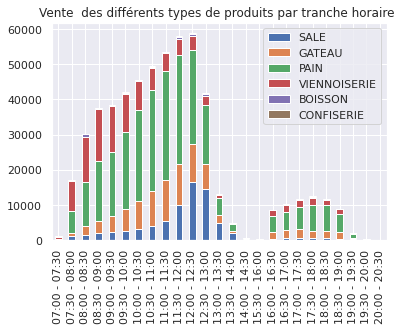

In [164]:
sns.set()
ca_prod_plot.plot(kind='bar', stacked=True,)
plt.xticks(ticks =range(25),labels = times)
plt.title("Vente  des différents types de produits par tranche horaire ")
plt.show()

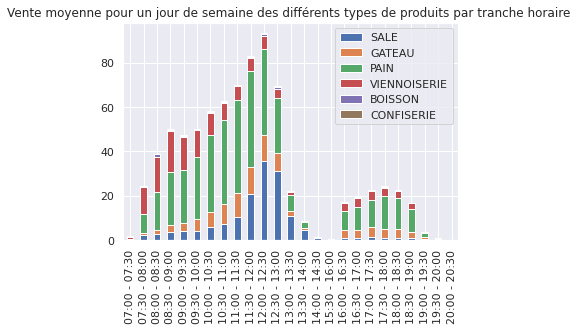

In [165]:
sns.set()
ca_prod_sem.plot(kind='bar', stacked=True,)
plt.xticks(ticks =range(25),labels = times)
plt.title("Vente moyenne pour un jour de semaine des différents types de produits par tranche horaire ")
plt.show()

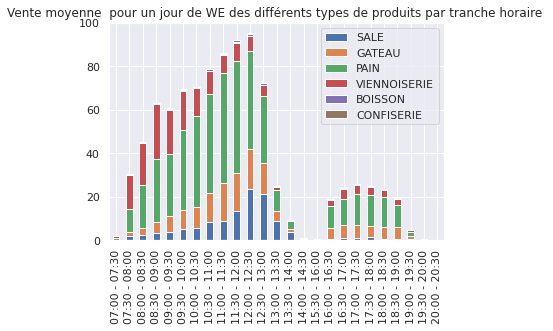

In [179]:
sns.set()
ca_prod_we.plot(kind='bar', stacked=True,)
plt.xticks(ticks =range(25),labels = times)
plt.title("Vente moyenne  pour un jour de WE des différents types de produits par tranche horaire ")
plt.show()